Code to classify the floats into clusters using Nick's pre-defined clusters as the labeled data

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import zipfile
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
import sys
sys.path.append('../')
from utils.get_season import get_season
from xgboost import XGBClassifier
import pickle

In [2]:
#read in data
date_parser = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
df = pd.read_csv("../../data/satData_clusters.csv",parse_dates=['date'], date_parser=date_parser)
df.head()

,float,cluster,cycleNumber,date,latitude,longitude,elevation,MO_SAT_SST,MO_SAT_CHL,MO_SAT_BBP,LT_SAT_SST_SD,LT_SAT_SST_MED,LT_SAT_CHL_SD,LT_SAT_CHL_MED,LT_SAT_BBP_SD,LT_SAT_BBP_MED
0,1902303,NaN,1,2021-05-06 02:03:16,49.236,-14.742,-4539.0,12.451869,0.435093,0.003340,2.156995,12.796509,0.253809,0.401662,0.000819,0.002213
1,1902303,NaN,2,2021-05-06 19:32:57,49.096,-14.617,-4612.0,12.466026,0.782180,0.003081,2.214400,12.673785,0.222806,0.398969,0.000793,0.002114
2,1902303,NaN,3,2021-05-07 20:05:38,48.914,-14.606,-4700.0,12.424099,0.458020,0.003185,2.211703,12.808284,0.279028,0.428079,0.000752,0.002105
3,1902303,NaN,4,2021-05-08 22:42:52,48.794,-14.689,-4753.0,12.374519,0.378064,0.001767,2.200517,13.010804,0.278832,0.422287,0.000679,0.002087
4,1902303,NaN,5,2021-05-09 20:29:00,48.719,-14.795,-4765.0,12.204494,0.411479,0.001677,2.232417,12.931680,0.334429,0.419105,0.000776,0.002090


In [3]:
#Create the unique ID for each float/cycle - these will be the unique observations
df['float_cycle'] = df['float'].map(str)+'_'+df['cycleNumber'].map(str)

In [4]:
# add a column for the day of the year in radians
df.insert(loc=list(df.columns).index('date')+1, column='day_of_year_rad', value=[(int(d.strftime('%j'))*np.pi)/182.625 for d in df['date']])

In [5]:
df.head()

,float,cluster,cycleNumber,date,day_of_year_rad,latitude,longitude,elevation,MO_SAT_SST,MO_SAT_CHL,MO_SAT_BBP,LT_SAT_SST_SD,LT_SAT_SST_MED,LT_SAT_CHL_SD,LT_SAT_CHL_MED,LT_SAT_BBP_SD,LT_SAT_BBP_MED,float_cycle
0,1902303,NaN,1,2021-05-06 02:03:16,2.167505,49.236,-14.742,-4539.0,12.451869,0.435093,0.003340,2.156995,12.796509,0.253809,0.401662,0.000819,0.002213,1902303_1
1,1902303,NaN,2,2021-05-06 19:32:57,2.167505,49.096,-14.617,-4612.0,12.466026,0.782180,0.003081,2.214400,12.673785,0.222806,0.398969,0.000793,0.002114,1902303_2
2,1902303,NaN,3,2021-05-07 20:05:38,2.184708,48.914,-14.606,-4700.0,12.424099,0.458020,0.003185,2.211703,12.808284,0.279028,0.428079,0.000752,0.002105,1902303_3
3,1902303,NaN,4,2021-05-08 22:42:52,2.201910,48.794,-14.689,-4753.0,12.374519,0.378064,0.001767,2.200517,13.010804,0.278832,0.422287,0.000679,0.002087,1902303_4
4,1902303,NaN,5,2021-05-09 20:29:00,2.219113,48.719,-14.795,-4765.0,12.204494,0.411479,0.001677,2.232417,12.931680,0.334429,0.419105,0.000776,0.002090,1902303_5


In [6]:
#Columns of interest: 'float', 'cycleNumber', 'latitude', 'longitude', 'date', 'sat_chl', 'sat_sst', 'sat_pic', 'sat_par', 'sat_aph_443'
#Read in dataframe with satellite data
zf = zipfile.ZipFile("../../data/float_loc_data_new_vars.csv.zip") 
sat_df = pd.read_csv(zf.open('float_loc_data_new_vars2.csv'))
sat_df.head()

,float,latitude,longitude,cycleNumber,date,PRES,PSAL,TEMP,BBP700,CHLA,...,sat_pic,sat_Rrs_678,sat_aph_443,sat_par,sat_angstrom,sat_bb_678,sat_adg_443,sat_aot_869,sat_adg_s,sat_bbp_s
0,1902303,49.236,-14.742,1,2021-05-06 02:03:16,3,35.539001,12.378333,0.001788,0.695875,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
1,1902303,49.236,-14.742,1,2021-05-06 02:03:16,4,35.539001,12.378333,0.001788,0.695875,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
2,1902303,49.236,-14.742,1,2021-05-06 02:03:16,6,35.539001,12.378667,0.001788,0.696499,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
3,1902303,49.236,-14.742,1,2021-05-06 02:03:16,8,35.539001,12.379000,0.001789,0.716489,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
4,1902303,49.236,-14.742,1,2021-05-06 02:03:16,10,35.539001,12.379000,0.001790,0.715552,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373


In [7]:
#Keep CHLA by depth data for later analysis after clustering
chla_distribution = sat_df[['float','cycleNumber','PRES','CHLA']]
#Create the unique ID for each float/cycle - these will be the unique observations
chla_distribution['float_cycle'] = chla_distribution['float'].map(str)+'_'+chla_distribution['cycleNumber'].map(str)
chla_distribution = chla_distribution.drop(['float','cycleNumber'], axis=1)
chla_distribution = chla_distribution[chla_distribution['PRES'] <= 250]

/var/folders/8w/yzz7q0p146x4qrt7dwp0mhy40000gn/T/ipykernel_3193/3322222213.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chla_distribution['float_cycle'] = chla_distribution['float'].map(str)+'_'+chla_distribution['cycleNumber'].map(str)


In [8]:
## keep only columns of interest:
sat_df = sat_df[['float', 'cycleNumber', 'sat_chl','sat_sst', 'sat_poc','sat_bbp_443', 'sat_pic', 'sat_aph_443', 'sat_par','sat_bb_678']].drop_duplicates()

In [9]:
#Create the unique ID for each float/cycle - these will be the unique observations
sat_df['float_cycle'] = sat_df['float'].map(str)+'_'+sat_df['cycleNumber'].map(str)
sat_df = sat_df.drop(['float','cycleNumber'], axis=1)

In [10]:
#Join the cluster data with the satellite data on float/cycle
cluster_df = df.merge(sat_df, on='float_cycle', how='left')
cluster_df.head()

,float,cluster,cycleNumber,date,day_of_year_rad,latitude,longitude,elevation,MO_SAT_SST,MO_SAT_CHL,...,LT_SAT_BBP_MED,float_cycle,sat_chl,sat_sst,sat_poc,sat_bbp_443,sat_pic,sat_aph_443,sat_par,sat_bb_678
0,1902303,NaN,1,2021-05-06 02:03:16,2.167505,49.236,-14.742,-4539.0,12.451869,0.435093,...,0.002213,1902303_1,0.370203,12.610000,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995
1,1902303,NaN,2,2021-05-06 19:32:57,2.167505,49.096,-14.617,-4612.0,12.466026,0.782180,...,0.002114,1902303_2,0.553922,12.815000,109.399902,0.003030,0.000188,0.0405,52.312000,0.001980
2,1902303,NaN,3,2021-05-07 20:05:38,2.184708,48.914,-14.606,-4700.0,12.424099,0.458020,...,0.002105,1902303_3,0.506032,12.480000,107.399902,0.003015,0.000192,0.0395,16.085999,0.001950
3,1902303,NaN,4,2021-05-08 22:42:52,2.201910,48.794,-14.689,-4753.0,12.374519,0.378064,...,0.002087,1902303_4,0.694757,12.639999,125.000000,0.003025,0.000136,0.0486,54.299999,0.002040
4,1902303,NaN,5,2021-05-09 20:29:00,2.219113,48.719,-14.795,-4765.0,12.204494,0.411479,...,0.002090,1902303_5,0.509723,12.375000,111.600098,0.002080,0.000080,0.0231,55.393997,0.001475


In [11]:
#Double check that floats may belong to multiple clusters (different cycles affect this)
test = cluster_df[['float','cluster']].drop_duplicates().dropna()
print(len(test), ' unique float/cluster combos')
print(len(test['float'].unique()), ' unique floats')

234  unique float/cluster combos
204  unique floats


In [12]:
# Data preprocessing - change the date to a datetime index
cluster_df['month'] = cluster_df['date'].apply(lambda x: x.month)

In [13]:
#Capture seasonality in the data
month_seasons_dict = {
    1: [1, 3],
    2: [1, 3],
    3: [2, 4],
    4: [2, 4],
    5: [2, 4],
    6: [3, 1],
    7: [3, 1],
    8: [3, 1],
    9: [4, 2],
    10: [4, 2],
    11: [4,2],
    12: [1, 3],
}
#Dictionary for our own understanding of the seasons mapping
seasons_dict = {
    1: 'Winter',
    2: 'Spring',
    3: 'Summer',
    4: 'Fall'
}

In [14]:
#Add column for seasonality
cluster_df['season'] = cluster_df.apply(lambda x: get_season(x, month_seasons_dict), axis=1)

In [15]:
cluster_df.head()

,float,cluster,cycleNumber,date,day_of_year_rad,latitude,longitude,elevation,MO_SAT_SST,MO_SAT_CHL,...,sat_chl,sat_sst,sat_poc,sat_bbp_443,sat_pic,sat_aph_443,sat_par,sat_bb_678,month,season
0,1902303,NaN,1,2021-05-06 02:03:16,2.167505,49.236,-14.742,-4539.0,12.451869,0.435093,...,0.370203,12.610000,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2
1,1902303,NaN,2,2021-05-06 19:32:57,2.167505,49.096,-14.617,-4612.0,12.466026,0.782180,...,0.553922,12.815000,109.399902,0.003030,0.000188,0.0405,52.312000,0.001980,5,2
2,1902303,NaN,3,2021-05-07 20:05:38,2.184708,48.914,-14.606,-4700.0,12.424099,0.458020,...,0.506032,12.480000,107.399902,0.003015,0.000192,0.0395,16.085999,0.001950,5,2
3,1902303,NaN,4,2021-05-08 22:42:52,2.201910,48.794,-14.689,-4753.0,12.374519,0.378064,...,0.694757,12.639999,125.000000,0.003025,0.000136,0.0486,54.299999,0.002040,5,2
4,1902303,NaN,5,2021-05-09 20:29:00,2.219113,48.719,-14.795,-4765.0,12.204494,0.411479,...,0.509723,12.375000,111.600098,0.002080,0.000080,0.0231,55.393997,0.001475,5,2


In [16]:
#Drop data not in our set: 
cluster_df = cluster_df.drop(['MO_SAT_SST', 'MO_SAT_CHL',
       'MO_SAT_BBP', 'LT_SAT_SST_SD', 'LT_SAT_SST_MED', 'LT_SAT_CHL_SD',
       'LT_SAT_CHL_MED', 'LT_SAT_BBP_SD', 'LT_SAT_BBP_MED'], axis=1)

Separate data into the train/test data and the new data for predictions

In [17]:
new_data = cluster_df[cluster_df['cluster'].isna()]
model_data = cluster_df[-cluster_df['cluster'].isna()]

In [18]:
#Add bins to stratify the data cut into train/test
model_data['lon_bin'] = pd.cut(model_data['longitude'],np.arange(-180,190,10))
model_data['lat_bin'] = pd.cut(model_data['latitude'],np.arange(-90,100,10))

/var/folders/8w/yzz7q0p146x4qrt7dwp0mhy40000gn/T/ipykernel_3193/3165825513.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['lon_bin'] = pd.cut(model_data['longitude'],np.arange(-180,190,10))
/var/folders/8w/yzz7q0p146x4qrt7dwp0mhy40000gn/T/ipykernel_3193/3165825513.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['lat_bin'] = pd.cut(model_data['latitude'],np.arange(-90,100,10))


In [19]:
test_model_data = model_data.dropna()
len(model_data) - len(test_model_data)

6081

In [20]:
model_data = model_data.dropna(subset=['latitude','longitude','season'])

In [55]:
#Sample 1 observation for each season/lat/lon for the test set
test_set = model_data.groupby(['lon_bin','lat_bin','season']).apply(lambda x: x.sample(1)).reset_index(drop=True)
#Remove these observations from the train data
train_set = model_data[-model_data['float_cycle'].isin(test_set['float_cycle'].unique())]
print('test size: ',round(len(test_set)/(len(test_set)+len(train_set))*100,0),'%')
#Now pull from train_set and sample 18% of remaining obeservations for each season/lat/lon
test_set_new = train_set.groupby(['lon_bin','lat_bin','season']).apply(lambda x: x.sample(frac=.17)).reset_index(drop=True)
test_set = pd.concat([test_set,test_set_new])
#Remove these observations from the train data
train_set = train_set[-train_set['float_cycle'].isin(test_set['float_cycle'].unique())]
print('test size: ',round(len(test_set)/(len(test_set)+len(train_set))*100,0),'%')


test size:  3.0 %
test size:  20.0 %


In [22]:
#Are all clusters in both train and test?
sorted(test_set['cluster'].unique()) == sorted(train_set['cluster'].unique())

True

In [23]:
train_set['cluster'].value_counts()

LCB     7120
HCB     3700
SDCM    3001
EQ      2729
PDCM    2481
AR       545
Name: cluster, dtype: int64

In [24]:
test_set.head()

,float,cluster,cycleNumber,date,day_of_year_rad,latitude,longitude,elevation,float_cycle,sat_chl,...,sat_poc,sat_bbp_443,sat_pic,sat_aph_443,sat_par,sat_bb_678,month,season,lon_bin,lat_bin
0,5904688,HCB,124,2019-08-29 15:44:03,4.145784,-62.973,-178.311,-3549.0,5904688_124,NaN,...,NaN,NaN,NaN,NaN,0.303993,NaN,8,1,"(-180, -170]","(-70, -60]"
1,5904104,LCB,199,2016-09-28 00:25:02,4.679059,-63.248,-177.815,-3415.0,5904104_199,0.175149,...,50.199707,0.001205,0.00001,0.0139,9.061996,0.000915,9,2,"(-180, -170]","(-70, -60]"
2,5904688,HCB,137,2020-01-10 16:53:17,0.172024,-63.592,-178.557,-3525.0,5904688_137,0.095897,...,54.000000,0.003985,0.00049,0.0094,36.755997,0.002155,1,3,"(-180, -170]","(-70, -60]"
3,5905377,LCB,84,2020-05-22 05:51:49,2.459947,-60.746,-175.636,-4073.0,5905377_84,NaN,...,NaN,NaN,NaN,NaN,0.779999,NaN,5,4,"(-180, -170]","(-70, -60]"
4,5904179,LCB,47,2015-07-15 01:58:52,3.371675,-58.065,-170.292,-4597.0,5904179_47,NaN,...,NaN,NaN,NaN,NaN,3.517998,NaN,7,1,"(-180, -170]","(-60, -50]"


In [25]:
cluster_names = train_set['cluster'].unique()
cluster_names

array(['EQ', 'AR', 'LCB', 'PDCM', 'SDCM', 'HCB'], dtype=object)

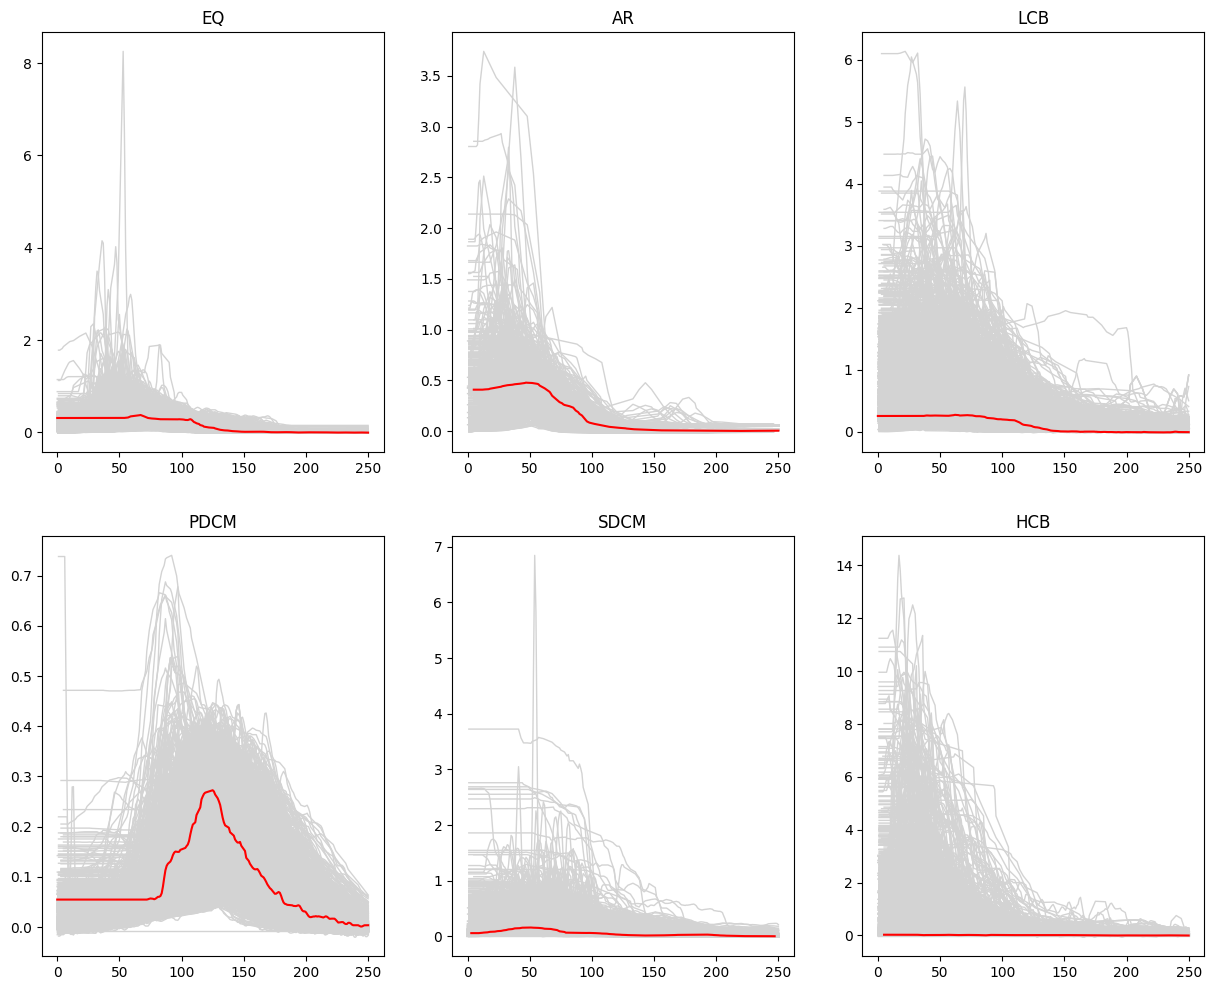

In [36]:
#View the distributions of floats within each cluster:
plt.figure(figsize=(15, 12))
for n, cluster_name in enumerate(cluster_names):
    cluster_float_cycles = train_set[train_set['cluster'] == cluster_name]['float_cycle']
    #pull 100 random samples to plot
    # randomlist = random.sample(range(0, len(cluster_float_cycles)), 100)
    plt.subplot(2,3, n + 1)
    small_df_full = chla_distribution[chla_distribution['float_cycle'].isin(cluster_float_cycles) ]
    for id in cluster_float_cycles:
        small_df = small_df_full[small_df_full['float_cycle']==id ]
        plt.plot(small_df['PRES'],small_df['CHLA'],color='lightgray',linewidth=1)
    plt.plot(small_df[['PRES','CHLA']].groupby('PRES').agg('mean'), color='red')
    plt.title(cluster_name)

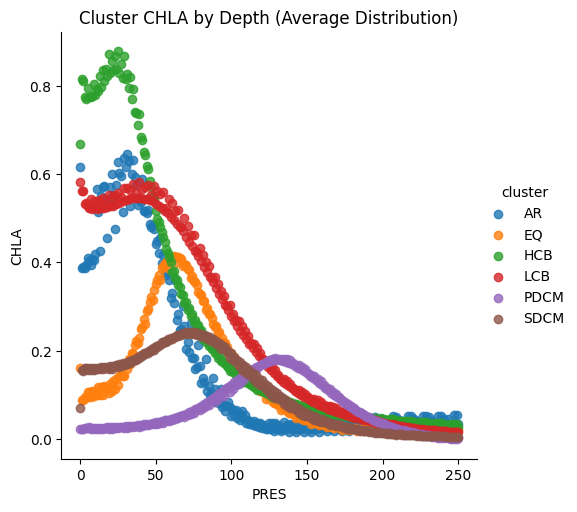

In [37]:
cluster_assignments = model_data[['cluster','float_cycle']]
#train_set[['cluster']].reset_index()
test = chla_distribution.merge(cluster_assignments, on='float_cycle')
test = test[['cluster','PRES','CHLA']].groupby(['cluster','PRES']).agg('mean').reset_index()
_ = sns.lmplot(x='PRES',y='CHLA', hue='cluster',data=test, fit_reg=False)
_ = plt.title('Cluster CHLA by Depth (Average Distribution)')
# _ = plt.gca().invert_yaxis()

In [28]:
# test.to_csv('../../data/cluster_chla_distribution.csv',index=False)

## KNN Classifier

In [56]:
drop_cols = ['float','cluster','cycleNumber','date','lon_bin','lat_bin']
index_col = 'float_cycle'
train_set_all_cols = train_set.dropna(inplace=False)
train_set_all_cols = train_set_all_cols.set_index([index_col])
test_set_all_cols = test_set.dropna(inplace=False)
test_set_all_cols = test_set_all_cols.set_index([index_col])
y_train, y_test = train_set_all_cols['cluster'], test_set_all_cols['cluster']
x_train, x_test = train_set_all_cols.drop(drop_cols, axis=1), test_set_all_cols.drop(drop_cols, axis=1)
x_train.head()

,day_of_year_rad,latitude,longitude,elevation,sat_chl,sat_sst,sat_poc,sat_bbp_443,sat_pic,sat_aph_443,sat_par,sat_bb_678,month,season
float_cycle,,,,,,,,,,,,,,
2902086_3,0.017202,12.226748,88.674653,-3143.0,0.151244,29.029999,50.399902,0.001675,0.00001,0.0112,37.889999,0.001100,1,1
2902086_4,0.034405,12.255253,88.660667,-3137.0,0.148740,28.719999,49.199707,0.001615,0.00001,0.0110,23.099998,0.001070,1,1
2902086_5,0.051607,12.279345,88.662178,-3133.0,0.148740,28.719999,49.199707,0.001615,0.00001,0.0110,31.523998,0.001070,1,1
2902086_6,0.068810,12.305605,88.652755,-3129.0,0.143393,29.439999,47.600098,0.001560,0.00001,0.0111,45.358002,0.001045,1,1
2902086_7,0.086012,12.321588,88.645502,-3128.0,0.156987,29.119999,54.399902,0.001905,0.00001,0.0120,45.952000,0.001210,1,1


In [57]:
x_train.columns

Index(['day_of_year_rad', 'latitude', 'longitude', 'elevation', 'sat_chl',
       'sat_sst', 'sat_poc', 'sat_bbp_443', 'sat_pic', 'sat_aph_443',
       'sat_par', 'sat_bb_678', 'month', 'season'],
      dtype='object')

In [58]:
#KNN with all variables
knn = KNeighborsClassifier(n_neighbors = 6, weights='distance').fit(x_train, y_train)
  
# accuracy on X_test
accuracy = knn.score(x_test, y_test)
print(accuracy)

0.8797345866740393


In [59]:
# training a KNN classifier without the month or elevation variable
drop_cols = ['float','cluster','cycleNumber','date','lon_bin','lat_bin']
index_col = 'float_cycle'
train_set_subset_cols = train_set.set_index([index_col])
test_set_subset_cols = test_set.set_index([index_col])
y_train, y_test = train_set_subset_cols['cluster'], test_set_subset_cols['cluster']
x_train, x_test = train_set_subset_cols.drop(drop_cols, axis=1), test_set_subset_cols.drop(drop_cols, axis=1)

knn = KNeighborsClassifier(n_neighbors = 6, weights='distance').fit(x_train[['day_of_year_rad', 'latitude', 'longitude', 'season']], y_train)
  
# accuracy on X_test
accuracy = knn.score(x_test[['day_of_year_rad', 'latitude', 'longitude', 'season']], y_test)
print(accuracy)

0.9805825242718447


In [60]:
knn_predictions = knn.predict(x_test[['day_of_year_rad', 'latitude', 'longitude', 'season']])

In [61]:
knn_results = pd.DataFrame(list(zip(knn_predictions, y_test)), columns=['y_hat','y_test'])
errors = dict(zip(list(cluster_names), [None]*len(cluster_names)))
knn_results['false_negative'] = np.where(knn_results['y_hat'] != knn_results['y_test'], knn_results['y_test'],0)
# knn_results['false_positive'] = np.where(knn_results['y_hat'] != knn_results['y_test'], knn_results['y_hat'],0)
knn_summary = pd.DataFrame(knn_results['false_negative'].value_counts()).reset_index()
overall_count = pd.DataFrame(knn_results['y_test'].value_counts()).reset_index()
knn_summary = knn_summary.merge(overall_count, on='index')
knn_summary.index = knn_summary['index']
knn_summary = knn_summary.drop('index',axis=1)
knn_summary.loc['Total'] = knn_summary.sum()
knn_summary['false_negative_pct'] = round(knn_summary['false_negative']/knn_summary['y_test']*100,0)
knn_summary


,false_negative,y_test,false_negative_pct
index,,,
HCB,45,932,5.0
LCB,33,1789,2.0
SDCM,12,706,2.0
AR,3,133,2.0
EQ,1,647,0.0
Total,94,4207,2.0


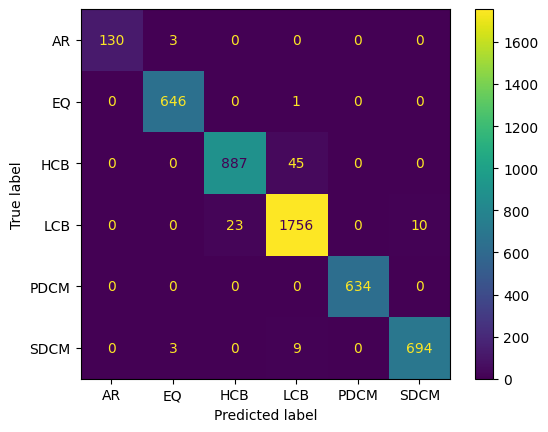

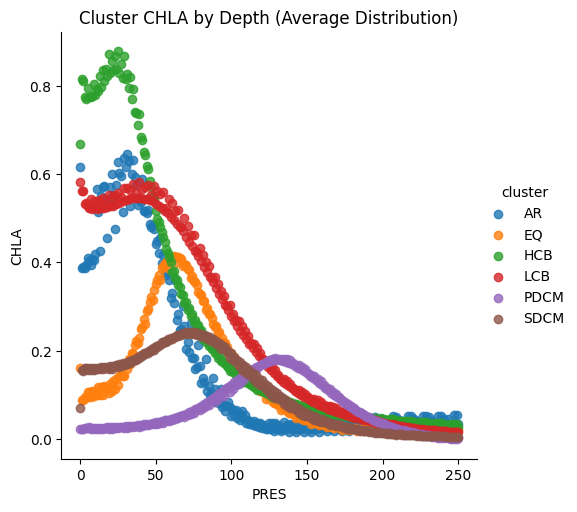

In [66]:
cm = confusion_matrix(y_test, knn_predictions, labels=sorted(cluster_names))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(cluster_names))
# plt.subplot(1,2,1)
disp.plot()
plt.show()
# plt.subplot(1,2,2)
cluster_assignments = model_data[['cluster','float_cycle']]
#train_set[['cluster']].reset_index()
test = chla_distribution.merge(cluster_assignments, on='float_cycle')
test = test[['cluster','PRES','CHLA']].groupby(['cluster','PRES']).agg('mean').reset_index()
_ = sns.lmplot(x='PRES',y='CHLA', hue='cluster',data=test, fit_reg=False)
_ = plt.title('Cluster CHLA by Depth (Average Distribution)')
# _ = plt.gca().invert_yaxis()

In [63]:
knn_results = pd.DataFrame(list(zip(knn_predictions, y_test)), columns=['y_hat','y_test'])
errors = dict(zip(list(cluster_names), [None]*len(cluster_names)))
# knn_results['false_negative'] = np.where(knn_results['y_hat'] != knn_results['y_test'], knn_results['y_test'],0)
knn_results['false_positive'] = np.where(knn_results['y_hat'] != knn_results['y_test'], knn_results['y_hat'],0)
knn_summary = pd.DataFrame(knn_results['false_positive'].value_counts()).reset_index()
overall_count = pd.DataFrame(knn_results['y_test'].value_counts()).reset_index()
knn_summary = knn_summary.merge(overall_count, on='index')
knn_summary.index = knn_summary['index']
knn_summary = knn_summary.drop('index',axis=1)
knn_summary.loc['Total'] = knn_summary.sum()
knn_summary['false_positive_pct'] = round(knn_summary['false_positive']/knn_summary['y_test']*100,0)
knn_summary

,false_positive,y_test,false_positive_pct
index,,,
LCB,55,1789,3.0
HCB,23,932,2.0
SDCM,10,706,1.0
EQ,6,647,1.0
Total,94,4074,2.0


In [156]:
#Predict on new data
new_data = new_data.dropna(subset=['day_of_year_rad', 'latitude', 'longitude', 'season'])
new_data_prediction = knn.predict(new_data[['day_of_year_rad', 'latitude', 'longitude', 'season']])

In [158]:
#Save model
# pickle.dump(knn, open('../../models/knearestneighbors_cluster_classification','wb'))

In [159]:
# knn_model = pickle.load(open('../../models/knearestneighbors_cluster_classification','rb'))

In [160]:
#Get all cluster assignments and save for later use
new_data['cluster'] = new_data_prediction
new_data['prediction'] = 1
model_data['prediction'] = 0
full_data = pd.concat([model_data,new_data],axis=0)
# full_data.to_csv('../../data/cluster_classification_assignment.csv',index=False)

## One against rest models - (worse results than knn)

In [216]:
one_hot_train = pd.get_dummies(train_set['cluster'])
train_set_oh = pd.concat([train_set, one_hot_train], axis=1)
train_set_oh.head()

,float,cluster,cycleNumber,date,day_of_year_rad,latitude,longitude,elevation,float_cycle,sat_chl,...,month,season,lon_bin,lat_bin,AR,EQ,HCB,LCB,PDCM,SDCM
239,2902086,EQ,3,2013-01-01 03:49:00,0.017202,12.226748,88.674653,-3143.0,2902086_3,0.151244,...,1,1,"(80, 90]","(10, 20]",0,1,0,0,0,0
240,2902086,EQ,4,2013-01-02 03:28:00,0.034405,12.255253,88.660667,-3137.0,2902086_4,0.148740,...,1,1,"(80, 90]","(10, 20]",0,1,0,0,0,0
241,2902086,EQ,5,2013-01-03 03:21:00,0.051607,12.279345,88.662178,-3133.0,2902086_5,0.148740,...,1,1,"(80, 90]","(10, 20]",0,1,0,0,0,0
242,2902086,EQ,6,2013-01-04 03:30:00,0.068810,12.305605,88.652755,-3129.0,2902086_6,0.143393,...,1,1,"(80, 90]","(10, 20]",0,1,0,0,0,0
243,2902086,EQ,7,2013-01-05 03:27:00,0.086012,12.321588,88.645502,-3128.0,2902086_7,0.156987,...,1,1,"(80, 90]","(10, 20]",0,1,0,0,0,0


In [217]:
one_hot_test = pd.get_dummies(test_set['cluster'])
test_set_oh = pd.concat([test_set, one_hot_test], axis=1)
test_set_oh.head()

,float,cluster,cycleNumber,date,day_of_year_rad,latitude,longitude,elevation,float_cycle,sat_chl,...,month,season,lon_bin,lat_bin,AR,EQ,HCB,LCB,PDCM,SDCM
0,5904688,HCB,132,2019-11-20 04:09:18,5.573585,-62.053,-175.886,-3870.0,5904688_132,0.660979,...,11,2,"(-180, -170]","(-70, -60]",0,0,1,0,0,0
1,5905099,HCB,26,2017-12-24 10:09:30,6.158468,-61.112,-170.668,-4207.0,5905099_26,0.992604,...,12,3,"(-180, -170]","(-70, -60]",0,0,1,0,0,0
2,5904688,HCB,142,2020-03-02 09:52:30,1.066550,-63.057,-176.837,-3467.0,5904688_142,0.190121,...,3,4,"(-180, -170]","(-70, -60]",0,0,1,0,0,0
3,5904179,LCB,87,2016-08-30 11:32:13,4.180189,-54.768,-170.984,-5023.0,5904179_87,0.179866,...,8,1,"(-180, -170]","(-60, -50]",0,0,0,1,0,0
4,5904179,HCB,23,2014-11-09 05:59:03,5.384359,-57.649,-174.128,-4918.0,5904179_23,0.200516,...,11,2,"(-180, -170]","(-60, -50]",0,0,1,0,0,0


In [218]:
cluster_names = train_set_oh['cluster'].unique()
cluster_names

array(['EQ', 'AR', 'LCB', 'PDCM', 'SDCM', 'HCB'], dtype=object)

In [134]:
#Remove unnecessary columns:
# drop_cols = ['float','cluster','cycleNumber','date','float_cycle','lon_bin','lat_bin']
# train_set = train_set.drop(drop_cols, axis=1)
# test_set = test_set.drop(drop_cols, axis=1)

### LCB model

In [219]:
cluster_name = 'LCB'
#Drop columns with cluster info, first make cluster of interest into y data
#Remove unnecessary columns:
drop_cols = ['float','cluster','cycleNumber','date','float_cycle','lon_bin','lat_bin']
y_train, y_test = train_set_oh[[cluster_name]], test_set_oh[[cluster_name]]
x_train, x_test = train_set_oh.drop(list(cluster_names)+drop_cols, axis=1), test_set_oh.drop(list(cluster_names)+drop_cols, axis=1)

In [137]:
xgb = XGBClassifier()
xgb.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [138]:
y_hat = xgb.predict(x_test)

accuracy: 0.9747985953315431
precision: 0.9551593733117234
recall: 0.9784172661870504
roc/auc: 0.975530320634725
confusion_matrix percents by row:
 [[0.97264338 0.02735662]
 [0.02158273 0.97841727]]


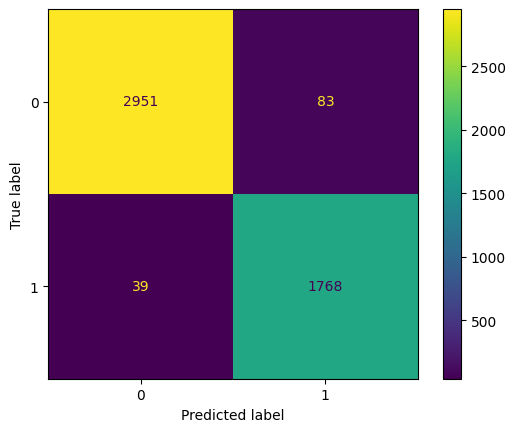

In [139]:
print('accuracy:', accuracy_score(y_test, y_hat))
print('precision:', precision_score(y_test, y_hat))
print('recall:', recall_score(y_test, y_hat))
print('roc/auc:', roc_auc_score(y_test, y_hat))
cm = confusion_matrix(y_test, y_hat, labels=xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb.classes_)
disp.plot()
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('confusion_matrix percents by row:\n', cm)



In [140]:
y_hat_prob_LCB = xgb.predict_proba(x_test)
#Get probabilities that float/cycle is LCB
class1_LCB = [y for x,y in y_hat_prob_LCB]

### AR Model

In [141]:
cluster_name = 'AR'
#Drop columns with cluster info, first make cluster of interest into y data
y_train, y_test = train_set_oh[[cluster_name]], test_set_oh[[cluster_name]]
x_train, x_test = train_set_oh.drop(list(cluster_names)+drop_cols, axis=1), test_set_oh.drop(list(cluster_names)+drop_cols, axis=1)

In [142]:
xgb = XGBClassifier()
xgb.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [143]:
y_hat = xgb.predict(x_test)

accuracy: 0.999793431109275
precision: 1.0
recall: 0.9924812030075187
roc/auc: 0.9962406015037594
confusion_matrix percents by row:
 [[1.        0.       ]
 [0.0075188 0.9924812]]


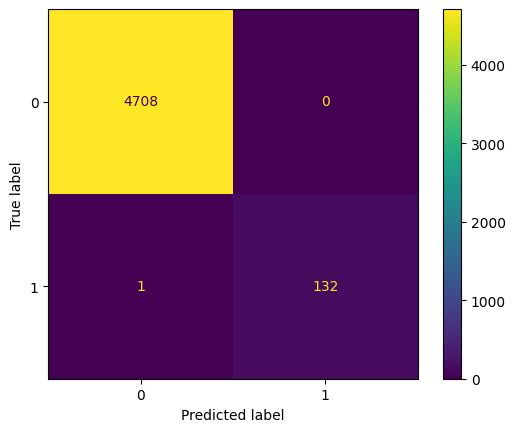

In [144]:
print('accuracy:', accuracy_score(y_test, y_hat))
print('precision:', precision_score(y_test, y_hat))
print('recall:', recall_score(y_test, y_hat))
print('roc/auc:', roc_auc_score(y_test, y_hat))
cm = confusion_matrix(y_test, y_hat, labels=xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb.classes_)
disp.plot()
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('confusion_matrix percents by row:\n', cm)



In [145]:
y_hat_prob_AR = xgb.predict_proba(x_test)
#Get probabilities that float/cycle is LCB
class1_AR = [y for x,y in y_hat_prob_AR]

### HCB Model

In [146]:
cluster_name = 'HCB'
#Drop columns with cluster info, first make cluster of interest into y data
y_train, y_test = train_set_oh[[cluster_name]], test_set_oh[[cluster_name]]
x_train, x_test = train_set_oh.drop(list(cluster_names)+drop_cols, axis=1), test_set_oh.drop(list(cluster_names)+drop_cols, axis=1)

In [147]:
xgb = XGBClassifier()
xgb.fit(x_train,y_train)
y_hat = xgb.predict(x_test)

accuracy: 0.9805825242718447
precision: 0.9715585893060296
recall: 0.9252437703141928
roc/auc: 0.9594314818901235
confusion_matrix percents by row:
 [[0.99361919 0.00638081]
 [0.07475623 0.92524377]]


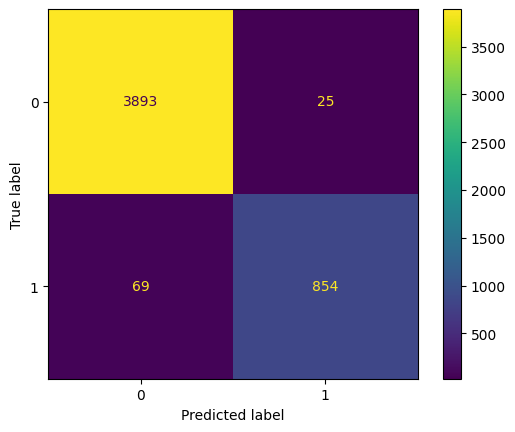

In [148]:
print('accuracy:', accuracy_score(y_test, y_hat))
print('precision:', precision_score(y_test, y_hat))
print('recall:', recall_score(y_test, y_hat))
print('roc/auc:', roc_auc_score(y_test, y_hat))
cm = confusion_matrix(y_test, y_hat, labels=xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb.classes_)
disp.plot()
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('confusion_matrix percents by row:\n', cm)

In [149]:
data = {'feature_importance':xgb.feature_importances_,'feature_names':x_train.columns}
fi_df = pd.DataFrame(data)
fi_df = fi_df.sort_values(by='feature_importance', ascending=False)
fi_df

,feature_importance,feature_names
1,0.518467,latitude
2,0.103705,longitude
5,0.086055,sat_sst
3,0.056543,elevation
0,0.037930,day_of_year_rad
6,0.031932,sat_poc
9,0.028325,sat_aph_443
13,0.026101,season
10,0.023402,sat_par
11,0.023078,sat_bb_678


In [150]:
y_hat_prob_HCB = xgb.predict_proba(x_test)
#Get probabilities that float/cycle is LCB
class1_HCB = [y for x,y in y_hat_prob_HCB]

### EQ Model

In [151]:
cluster_name = 'EQ'
#Drop columns with cluster info, first make cluster of interest into y data
y_train, y_test = train_set_oh[[cluster_name]], test_set_oh[[cluster_name]]
x_train, x_test = train_set_oh.drop(list(cluster_names)+drop_cols, axis=1), test_set_oh.drop(list(cluster_names)+drop_cols, axis=1)

In [152]:
xgb = XGBClassifier()
xgb.fit(x_train,y_train)
y_hat = xgb.predict(x_test)

accuracy: 0.9973146044205743
precision: 0.9937402190923318
recall: 0.9860248447204969
roc/auc: 0.9925358915048756
confusion_matrix percents by row:
 [[9.99046938e-01 9.53061711e-04]
 [1.39751553e-02 9.86024845e-01]]


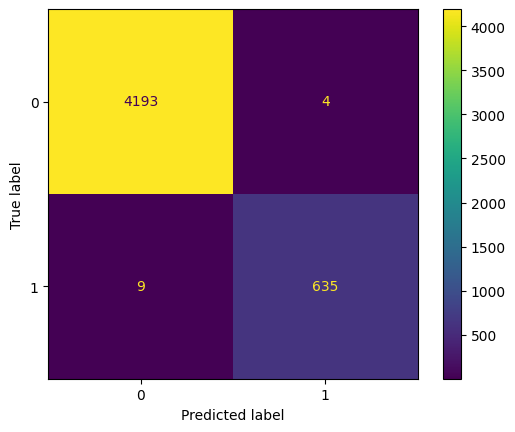

In [153]:
print('accuracy:', accuracy_score(y_test, y_hat))
print('precision:', precision_score(y_test, y_hat))
print('recall:', recall_score(y_test, y_hat))
print('roc/auc:', roc_auc_score(y_test, y_hat))
cm = confusion_matrix(y_test, y_hat, labels=xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb.classes_)
disp.plot()
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('confusion_matrix percents by row:\n', cm)

In [154]:
y_hat_prob_EQ = xgb.predict_proba(x_test)
#Get probabilities that float/cycle is LCB
class1_EQ = [y for x,y in y_hat_prob_EQ]

### PDCM Model

In [155]:
cluster_name = 'PDCM'
#Drop columns with cluster info, first make cluster of interest into y data
y_train, y_test = train_set_oh[[cluster_name]], test_set_oh[[cluster_name]]
x_train, x_test = train_set_oh.drop(list(cluster_names)+drop_cols, axis=1), test_set_oh.drop(list(cluster_names)+drop_cols, axis=1)

In [156]:
xgb = XGBClassifier()
xgb.fit(x_train,y_train)
y_hat = xgb.predict(x_test)

accuracy: 0.9985540177649246
precision: 0.9937304075235109
recall: 0.9952904238618524
roc/auc: 0.9971694745379672
confusion_matrix percents by row:
 [[9.99048525e-01 9.51474786e-04]
 [4.70957614e-03 9.95290424e-01]]


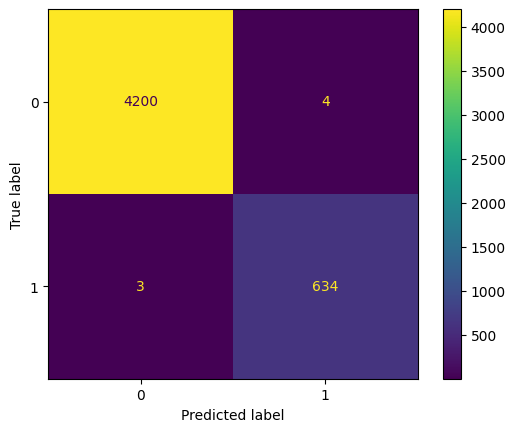

In [157]:
print('accuracy:', accuracy_score(y_test, y_hat))
print('precision:', precision_score(y_test, y_hat))
print('recall:', recall_score(y_test, y_hat))
print('roc/auc:', roc_auc_score(y_test, y_hat))
cm = confusion_matrix(y_test, y_hat, labels=xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb.classes_)
disp.plot()
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('confusion_matrix percents by row:\n', cm)

In [158]:
y_hat_prob_PDCM = xgb.predict_proba(x_test)
#Get probabilities that float/cycle is LCB
class1_PDCM = [y for x,y in y_hat_prob_PDCM]

### SDCM Model

In [159]:
cluster_name = 'SDCM'
#Drop columns with cluster info, first make cluster of interest into y data
y_train, y_test = train_set_oh[[cluster_name]], test_set_oh[[cluster_name]]
x_train, x_test = train_set_oh.drop(list(cluster_names)+drop_cols, axis=1), test_set_oh.drop(list(cluster_names)+drop_cols, axis=1)

In [160]:
xgb = XGBClassifier()
xgb.fit(x_train,y_train)
y_hat = xgb.predict(x_test)

accuracy: 0.9942160710596984
precision: 0.9826839826839827
recall: 0.9770444763271162
roc/auc: 0.9870743617156816
confusion_matrix percents by row:
 [[0.99710425 0.00289575]
 [0.02295552 0.97704448]]


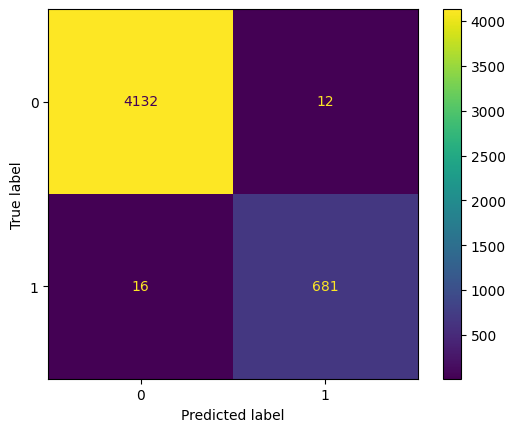

In [161]:
print('accuracy:', accuracy_score(y_test, y_hat))
print('precision:', precision_score(y_test, y_hat))
print('recall:', recall_score(y_test, y_hat))
print('roc/auc:', roc_auc_score(y_test, y_hat))
cm = confusion_matrix(y_test, y_hat, labels=xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb.classes_)
disp.plot()
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('confusion_matrix percents by row:\n', cm)

In [162]:
y_hat_prob_SDCM = xgb.predict_proba(x_test)
#Get probabilities that float/cycle is LCB
class1_SDCM = [y for x,y in y_hat_prob_SDCM]

## Combine Models

In [163]:
classes = ['class1_' + item for item in cluster_names]
classes

['class1_EQ',
 'class1_AR',
 'class1_LCB',
 'class1_PDCM',
 'class1_SDCM',
 'class1_HCB']

In [164]:
probabilities = list(zip(class1_EQ,class1_AR,class1_LCB,class1_PDCM,class1_SDCM,class1_HCB))
probabilities[0:10]

[(2.9876815e-05,
  1.6539323e-05,
  0.84468174,
  1.8891646e-05,
  1.6987975e-06,
  0.16189031),
 (0.000107833825,
  7.4133013e-06,
  0.8103367,
  1.1119794e-05,
  5.9636077e-06,
  0.15701649),
 (3.2446795e-05,
  3.2481625e-05,
  0.04996603,
  1.0600484e-05,
  5.7168913e-06,
  0.9498286),
 (3.345787e-05,
  2.2355347e-05,
  0.026069032,
  1.2680185e-05,
  9.152959e-06,
  0.8834603),
 (2.812693e-05,
  1.6539323e-05,
  0.9265563,
  1.8891646e-05,
  1.9605463e-06,
  0.19658689),
 (0.00033738016,
  9.55122e-06,
  0.04298787,
  9.984246e-06,
  4.5980128e-06,
  0.8489025),
 (3.8224483e-05,
  2.2662389e-05,
  0.9988512,
  1.4568048e-05,
  1.417167e-06,
  0.0011644241),
 (3.4433528e-05,
  2.2355347e-05,
  0.07174462,
  1.7153709e-05,
  2.195479e-06,
  0.8627708),
 (2.3646444e-05,
  1.6539323e-05,
  0.9915633,
  2.1490192e-05,
  4.618933e-06,
  0.0049844235),
 (5.0416933e-05,
  2.5939538e-05,
  0.99518543,
  9.965954e-06,
  0.00014758606,
  0.002174423)]

In [174]:
max_values = [np.argmax(i) for i in probabilities]
max_values[0:10]

[2, 2, 5, 5, 2, 5, 2, 5, 2, 2]

In [175]:
cluster_names

array(['EQ', 'AR', 'LCB', 'PDCM', 'SDCM', 'HCB'], dtype=object)

In [167]:
from collections import Counter

In [168]:
Counter(max_values)

Counter({2: 1861, 5: 876, 3: 638, 4: 691, 0: 643, 1: 132})

In [185]:
Max_values = pd.DataFrame(max_values, columns=['max_value'])

In [188]:
test_set_eval = test_set.join(Max_values)
test_set_eval.head()

,float,cluster,cycleNumber,date,day_of_year_rad,latitude,longitude,elevation,float_cycle,sat_chl,...,season,lon_bin,lat_bin,AR,EQ,HCB,LCB,PDCM,SDCM,max_value
0,5905377,LCB,87,2020-06-21 12:03:25,2.976019,-60.430,-175.407,-4128.0,5905377_87,NaN,...,1,"(-180, -170]","(-70, -60]",0,0,0,1,0,0,2
0,5904104,LCB,195,2016-08-30 01:15:15,4.180189,-62.920,-179.240,-3887.0,5904104_195,NaN,...,1,"(-180, -170]","(-70, -60]",0,0,0,1,0,0,2
1,5904104,LCB,207,2016-11-24 16:40:00,5.659597,-63.350,-174.075,-3120.0,5904104_207,0.151754,...,2,"(-180, -170]","(-70, -60]",0,0,0,1,0,0,2
1,5904688,HCB,151,2020-06-03 09:00:27,2.666376,-62.561,-172.454,-3423.0,5904688_151,NaN,...,1,"(-180, -170]","(-70, -60]",0,0,1,0,0,0,2
2,5904688,HCB,134,2019-12-10 19:26:47,5.917634,-62.126,-177.308,-4311.0,5904688_134,0.306162,...,3,"(-180, -170]","(-70, -60]",0,0,1,0,0,0,5


In [190]:
cluster_dict={}
for i, name in enumerate(cluster_names):
    cluster_dict[name] = i

In [191]:
cluster_dict

{'EQ': 0, 'AR': 1, 'LCB': 2, 'PDCM': 3, 'SDCM': 4, 'HCB': 5}

In [195]:
test_set_eval['cluster_num'] = test_set_eval['cluster'].map(cluster_dict)
test_set_eval.head()

,float,cluster,cycleNumber,date,day_of_year_rad,latitude,longitude,elevation,float_cycle,sat_chl,...,lon_bin,lat_bin,AR,EQ,HCB,LCB,PDCM,SDCM,max_value,cluster_num
0,5905377,LCB,87,2020-06-21 12:03:25,2.976019,-60.430,-175.407,-4128.0,5905377_87,NaN,...,"(-180, -170]","(-70, -60]",0,0,0,1,0,0,2,2
0,5904104,LCB,195,2016-08-30 01:15:15,4.180189,-62.920,-179.240,-3887.0,5904104_195,NaN,...,"(-180, -170]","(-70, -60]",0,0,0,1,0,0,2,2
1,5904104,LCB,207,2016-11-24 16:40:00,5.659597,-63.350,-174.075,-3120.0,5904104_207,0.151754,...,"(-180, -170]","(-70, -60]",0,0,0,1,0,0,2,2
1,5904688,HCB,151,2020-06-03 09:00:27,2.666376,-62.561,-172.454,-3423.0,5904688_151,NaN,...,"(-180, -170]","(-70, -60]",0,0,1,0,0,0,2,5
2,5904688,HCB,134,2019-12-10 19:26:47,5.917634,-62.126,-177.308,-4311.0,5904688_134,0.306162,...,"(-180, -170]","(-70, -60]",0,0,1,0,0,0,5,5


In [199]:
accuracy_score(test_set_eval['cluster_num'], test_set_eval['max_value'])

0.36232183433174964